In [76]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import json
from shapely.geometry import Polygon, MultiPolygon

## Microclimate sensor readings

In [6]:
base_url_v2 = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'
base_url_v2_1 = 'https://data.melbourne.vic.gov.au/api/explore/v2.1/catalog/datasets/'

#Dataset name
sensor_reading_dataset = 'microclimate-sensor-readings'
number_of_records = 100

# Add a filter for the number of results returned
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

In [5]:
sensor_reading_url = f'{base_url_v2}{sensor_reading_dataset}/{filters}'
sensor_reading_url

'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/microclimate-sensor-readings/records?limit=100&offset=0&timezone=UTC'

In [9]:
# Use requests to get the data
result = requests.get(sensor_reading_url)

In [10]:
result_json = result.json()

In [11]:
result_json.keys()

dict_keys(['total_count', 'links', 'records'])

In [12]:
result_json['total_count']

1340

In [13]:
records = result_json['records']

In [14]:
pm10_df = pd.json_normalize(records)
pm10_df.drop(columns = ['links'], inplace=True)

In [15]:
column_names = pm10_df.columns.values.tolist()
column_names = [i.split('.')[-1] for i in column_names]
pm10_df.columns = column_names

In [16]:
pm10_df

id                 timestamp  size  \
0   9f9b74b79e33f6ac7eaa6a99bd13c875dc0efa6c  2023-07-27T00:21:56.081Z    80   
1   086f643d075f06e64b4d73af7a7ee6bc0f3242da  2023-07-27T00:21:56.081Z    80   
2   04bd749003363e5644a9909f4b564a14c45796eb  2023-07-27T00:21:56.081Z    89   
3   b0f2dd975d9242c4b8188fdd77bb0c7e12123bb6  2023-07-27T00:21:56.081Z    81   
4   b6369e51c1f97a99371028d96f8f81acff8da909  2023-07-27T00:21:56.081Z    81   
..                                       ...                       ...   ...   
95  68a3cb9f288e8085b5669ff55ee63217240c9ba7  2023-07-27T00:21:56.081Z   123   
96  106b81f009dd10f90de8420daa50e98dbba571cf  2023-07-27T00:21:56.081Z    95   
97  b07ffdc323ba9a285d7d6e6705c8f9e79187c0c5  2023-07-27T00:21:56.081Z   108   
98  2c72c87da757dd56ceddedfa15ab2be98255bd96  2023-07-27T00:21:56.081Z   124   
99  230fd355f17c5cfe0521f19b78b0630740a28f52  2023-07-27T00:21:56.081Z    95   

                   local_time       id  site_id               sensor_id  \
0   2023-07-26T14:15:02+00:00  7595165     1014                      5b   
1   2023-07-26T14:15:05+00:00  7595073     1011                      5b   
2   2023-07-26T14:15:05+00:00  7595078     1011                      5c   
3   2023-07-26T14:15:05+00:00  7595112     1012                      5a   
4   2023-07-26T14:15:07+00:00  7595204     1016                      5a   
..                        ...      ...      ...                     ...   
95  2023-07-26T16:00:00+00:00  7595503     1012  0b.EPA-1h.NOPK.EPA-24h   
96  2023-07-26T16:00:00+00:00  7595518     1012               5a.EPA-1h   
97  2023-07-26T16:00:00+00:00  7595537     1014          0a.EPA-1h.NOPK   
98  2023-07-26T16:00:00+00:00  7595538     1014  0a.EPA-1h.NOPK.EPA-24h   
99  2023-07-26T16:00:00+00:00  7595566     1014               5a.EPA-1h   

      value                       type   units gatewayhub_id site_status  
0     80.14                     TPH.RH       %       arc1045           C  
1     75.54                     TPH.RH       %       arc1055           C  
2   1028.80               TPH.PRESSURE     hPa       arc1055           C  
3      8.72                   TPH.TEMP       C       arc1048           C  
4      9.35                   TPH.TEMP       C       arc1049           C  
..      ...                        ...     ...           ...         ...  
95    28.90   PM10-EPA-1h-NOPK-EPA-24h  ug/m^3       arc1048           C  
96     8.53            TPH.TEMP-EPA-1h       C       arc1048           C  
97    17.90          PM2.5-EPA-1h-NOPK  ug/m^3       arc1045           C  
98    11.20  PM2.5-EPA-1h-NOPK-EPA-24h  ug/m^3       arc1045           C  
99     8.21            TPH.TEMP-EPA-1h       C       arc1045           C  

[100 rows x 12 columns]

In [17]:
groupbyfields = ['site_id']
aggregatebyfields = ["count", "mean"]

# Create new DataFrame with value counts and mean values for each site.
pm10SiteCount = pd.DataFrame(pm10_df.groupby(groupbyfields, as_index=False)['value'].agg(aggregatebyfields)
                             .add_prefix('value_'))
pm10SiteCount = pm10SiteCount.reset_index()
pm10SiteCount

site_id  value_count  value_mean
0     1009            9   18.077778
1     1011           23  205.540000
2     1012           17   18.361176
3     1014           27   99.592963
4     1016           24  145.839167

In [9]:
# Function that extracts the data from the JSON url
def get_data(base, data_url, offset = 0):
    
    filters = f'records?limit={100}&offset={offset}&timezone=UTC'
    url = f'{base}{data_url}/{filters}'
    result = requests.get(url)
    # if you need to extract more than 9900 records, enter the api key like below
    #result = requests.get(url + f'&apikey={API_KEY}')
    result_json = result.json()
    max_results = result_json['total_count']
    links = result_json['links']
    records = result_json['records']
    records_df = pd.json_normalize(records)
    
    # fix columns names
    records_df.drop(columns=['links'],inplace=True)
    column_names = records_df.columns.values.tolist()
    
    column_names = [i.split('.')[-1] for i in column_names]
    records_df.columns = column_names
    
    next_url = None
    
    # get next url
    if records_df.shape[0] != max_results:
        for l in links:
            if l['rel']=='next':
                next_url = l['href']
                
    return [records_df, next_url, column_names]

In [3]:
def add_to_dataframe(dataframe, new_data):
    df = pd.concat([dataframe, new_data])
    return df

In [10]:
# Extracts the data from the JSON url to produce a pandas dataset
def extract_dataframe(dataset):
    df_new, url_next, column_names = get_data(base_url, dataset)
    df = pd.DataFrame(columns=column_names)
    while url_next != None:
        df_new, url_next, column_names = get_data(base_url, dataset, df.shape[0])
        df = add_to_dataframe(df, df_new)
        # This limits the dataset to only 9900 entries, should be removed if you want to import more data
        if df.shape[0] == 9900:
            break
    return df

In [35]:
df = extract_dataframe()

In [139]:
df

id                 timestamp size  \
36  dd8d29d84cd71b12369eb7001fa277e7782418d5  2023-07-27T00:21:56.081Z  123   
40  fda76ae324b5de994b46079e1024a21bb1e271ac  2023-07-27T00:21:56.081Z  123   
90  f2f2819ddc255311cd702c1501c1330d70f45eda  2023-07-27T00:21:56.081Z  123   
95  68a3cb9f288e8085b5669ff55ee63217240c9ba7  2023-07-27T00:21:56.081Z  123   
52  738d8333b9608a675fc50984efc6cea30b0e9675  2023-07-27T00:21:56.081Z  123   
39  16351400829e2e82abcf22c1d3d7121a3a17b6a8  2023-07-27T00:21:56.081Z  123   
81  277de71d315dd02e2b21c99d9c391928f2c94caa  2023-07-27T00:21:56.081Z  123   
86  64bf776c4fe62d2c8143feaa5d108b4350b1d9db  2023-07-27T00:21:56.081Z  123   
92  456d1482f821ff82ab4ce5356ce61b6ba3e6f143  2023-07-27T00:21:56.081Z  123   
2   ba7a323c12b8b9c31c4e9ff26edffad40be868b2  2023-07-27T00:21:56.081Z  123   
35  9d0f69a2006c0b9e5d12326a65f4fa76c23752c6  2023-07-27T00:21:56.081Z  123   
40  9a71251df3c4107d0fdfa50e2a887ff8257ec05a  2023-07-27T00:21:56.081Z  123   
94  f775b8c8c409843219db6e6225cc05abae2150c8  2023-07-27T00:21:56.081Z  123   
35  067fb261e9857262f9f2ea07e5289bb920bf35e1  2023-07-27T00:21:56.081Z  123   
10  1c3ad40bc862cf268fc5955a1778c02b5c9bd58e  2023-07-27T00:21:56.081Z  123   
18  e6fdb813268baa447523b5c2d17a0f94bddb90de  2023-07-27T00:21:56.081Z  123   
63  6ede1b2d0a08006108e4ac671b155ad6e159ac81  2023-07-27T00:21:56.081Z  123   
11  1db34a42236e7b9326f9889bdc29c8ee47817370  2023-07-27T00:21:56.081Z  123   
16  900bafebafd0d252aa782b4a1e476d399a12c88b  2023-07-27T00:21:56.081Z  123   
54  2c01864c61fb93f7d054ee903cc9217364859477  2023-07-27T00:21:56.081Z  123   
61  e9e1b7c36474d490a8e362c771c50eef019ff124  2023-07-27T00:21:56.081Z  123   
66  8e03b34737b9d8ddad3748b8b0dd5d9af6ac88ab  2023-07-27T00:21:56.081Z  123   
5   e586d65b4bef5aca657f83f058356719f6cec01c  2023-07-27T00:21:56.081Z  123   
9   1a16eede8db7095075e696e5e48b8dd062eaf11f  2023-07-27T00:21:56.081Z  123   
67  e73b39bcab9ceb1d6c84dea18aac83caad836844  2023-07-27T00:21:56.081Z  123   
71  73341b57d4bcbf94dc4b971cd0c8b004150317c3  2023-07-27T00:21:56.081Z  123   
14  541c9ac5b22be6b40ccdfb7991e3d3daebdea4b0  2023-07-27T00:21:56.081Z  123   
20  d900eb18d821a4c7bc897cd39fb60b17d8a75411  2023-07-27T00:21:56.081Z  123   
79  894635bbb4668f629d912509a809827968cf4c21  2023-07-27T00:21:56.081Z  123   
85  67005b90520d1a8b09382664dc068131c9e49332  2023-07-27T00:21:56.081Z  123   
88  e5f3a4f40a9c3e15c95f3359db406bbaaaf1ba3a  2023-07-27T00:21:56.081Z  123   

                  local_time       id site_id               sensor_id  value  \
36 2023-07-26 15:00:00+00:00  7595301    1012  0b.EPA-1h.NOPK.EPA-24h   28.7   
40 2023-07-26 15:00:00+00:00  7595345    1014  0b.EPA-1h.NOPK.EPA-24h   30.3   
90 2023-07-26 16:00:00+00:00  7595459    1011  0b.EPA-1h.NOPK.EPA-24h   27.3   
95 2023-07-26 16:00:00+00:00  7595503    1012  0b.EPA-1h.NOPK.EPA-24h   28.9   
52 2023-07-26 21:00:00+00:00  7596538    1014  0b.EPA-1h.NOPK.EPA-24h   31.6   
39 2023-07-26 16:00:00+00:00  7595595    1016  0b.EPA-1h.NOPK.EPA-24h   33.6   
81 2023-07-26 17:00:00+00:00  7595659    1011  0b.EPA-1h.NOPK.EPA-24h   27.4   
86 2023-07-26 17:00:00+00:00  7595703    1012  0b.EPA-1h.NOPK.EPA-24h   28.9   
92 2023-07-26 19:00:00+00:00  7596013    1011  0b.EPA-1h.NOPK.EPA-24h   27.9   
2  2023-07-26 19:00:00+00:00  7596185    1016  0b.EPA-1h.NOPK.EPA-24h   33.6   
35 2023-07-26 20:00:00+00:00  7596250    1011  0b.EPA-1h.NOPK.EPA-24h   28.3   
40 2023-07-26 20:00:00+00:00  7596294    1012  0b.EPA-1h.NOPK.EPA-24h   29.5   
94 2023-07-26 21:00:00+00:00  7596586    1016  0b.EPA-1h.NOPK.EPA-24h   33.2   
35 2023-07-26 22:00:00+00:00  7596787    1016  0b.EPA-1h.NOPK.EPA-24h   32.6   
10 2023-07-26 15:00:00+00:00  7595257    1011  0b.EPA-1h.NOPK.EPA-24h   26.9   
18 2023-07-26 15:00:00+00:00  7595393    1016  0b.EPA-1h.NOPK.EPA-24h   33.7   
63 2023-07-26 16:00:00+00:00  7595547    1014  0b.EPA-1h.NOPK.EPA-24h   30.5   
11 2023-07-26 17:00:00+00:00  7595747    1014  0b.EPA-1h.NOPK.EPA-24h   3

In [ ]:
groupbyfields = ['site_id']
aggregatebyfields = ["count", "mean"]

# Create new DataFrame with value counts and mean values for each site.
pm10SiteCount = pd.DataFrame(pm10_df.groupby(groupbyfields, as_index=False)['value'].agg(aggregatebyfields)
                             .add_prefix('value_'))
pm10SiteCount = pm10SiteCount.reset_index()
pm10SiteCount

In [37]:
df['local_time'] = pd.to_datetime(df['local_time'] )
df['local_time'].dtypes

datetime64[ns, UTC]

In [38]:
df = df.loc[df['type'] == 'PM10-EPA-1h-NOPK-EPA-24h']
df.shape

(31, 12)

In [68]:
df['site_id'].unique()

array([1012, 1014, 1011, 1016], dtype=object)

In [102]:
site_ids = [1011, 1012, 1014, 1016]
site_dfs = []

for site_id in site_ids:
    site_df = df.loc[df['site_id'] == site_id]
    site_df = site_df.sort_values(by='local_time')
    site_df = site_df[['local_time', 'value']]
    site_dfs.append(site_df)
    
site1011 = site_dfs[0]
site1012 = site_dfs[1]
site1014 = site_dfs[2]
site1016 = site_dfs[3]

C:\Users\playroommountains\AppData\Local\Temp\ipykernel_13980\1625188892.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(custom_tick_labels)


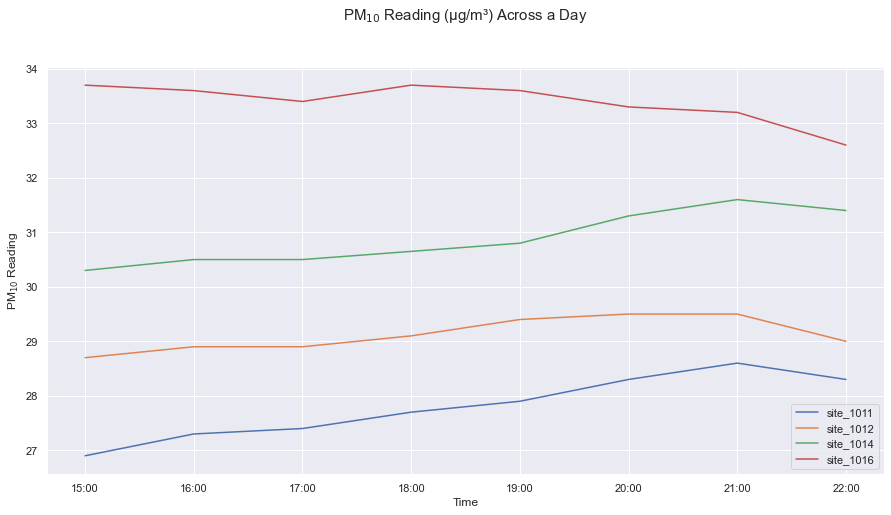

In [107]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(15, 7.5))

ax.plot(site1011['local_time'], site1011['value'], label = 'site_1011')
ax.plot(site1012['local_time'], site1012['value'], label = 'site_1012')
ax.plot(site1014['local_time'], site1014['value'], label = 'site_1014')
ax.plot(site1016['local_time'], site1016['value'], label = 'site_1016')

ax.set_xlabel("Time")
ax.set_ylabel("PM$_{10}$ Reading")
ax.set_title("PM$_{10}$ Reading (µg/m\u00b3) Across a Day", y=1.1, fontsize=15)

custom_tick_labels = ['15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00', '22:00']
ax.set_xticklabels(custom_tick_labels)

plt.legend()
plt.show()

## Microclimate sensor locations 

In [1]:
#Dataset name
sensor_location_dataset = 'microclimate-sensor-locations'
number_of_records = 20

filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

sensor_location_url = f'{base_url_v2_1}{sensor_location_dataset}/{filters}'
sensor_location_url

NameError: name 'base_url_v2_1' is not defined

In [130]:
result = requests.get(sensor_location_url)
result_json = result.json()
result_json['total_count']

In [118]:
results = result_json['results']

In [121]:
location_dataset = pd.json_normalize(results)
location_dataset

site_id gatewayhub_id site_status      last_data_local start_reading  \
0      1016       arc1049           C  2023-08-29 19:00:01    2021-09-17   
1      1002       arc1046           R                 None    2019-11-15   
2      1003       arc1047           R                 None    2019-11-15   
3      1015       arc1046           R                 None    2021-09-17   
4      1009       arc1050           C  2023-08-29 19:00:01    2021-06-14   
5      1007       arc1113           C  2022-07-20 15:00:01    2021-05-20   
6      1012       arc1048           C  2023-08-29 19:00:01    2021-09-17   
7      1014       arc1045           C  2023-08-29 19:00:01    2021-09-17   
8      1004       arc1048           R                 None    2019-11-15   
9      1006       arc1112           R                 None    2021-05-20   
10     1011       arc1055           C  2023-08-29 19:00:01    2021-07-07   
11     1008       arc1045           R                 None    2021-06-14   
12     1005       arc1050           R                 None    2019-11-15   
13     1013       arc1047           R                 None    2021-09-17   
14     1010       arc1112           C  2023-02-25 23:00:01    2021-06-29   
15     1001       arc1045           R                 None    2019-11-15   

   end_reading   latitude   longitude  location.lon  location.lat  
0         None -37.812778  144.960556    144.960556    -37.812778  
1   2021-06-13 -37.800524  144.964122    144.964122    -37.800524  
2   2021-06-13 -37.802300  144.960923    144.960923    -37.802300  
3         None -37.810278  144.972500    144.972500    -37.810278  
4         None -37.816868  144.965705    144.965705    -37.816868  
5         None -37.822460  144.951835    144.951835    -37.822460  
6         None -37.813333  144.970000    144.970000    -37.813333  
7         None -37.817500  144.967222    144.967222    -37.817500  
8   2021-06-13 -37.800575  144.964635    144.964635    -37.800575  
9   2021-06-28 -37.822486  144.952065    144.952065    -37.822486  
10        None -37.822222  144.952222    144.952222    -37.822222  
11  2021-06-20 -37.817465  144.967057    144.967057    -37.817465  
12  2021-06-13 -37.800629  144.965052    144.965052    -37.800629  
13        None -37.811944  144.956389    144.956389    -37.811944  
14        None -37.822500  144.952222    144.952222    -37.822500  
15  2021-06-13 -37.800793  144.966492    144.966492    -37.800793

In [127]:
# Merging sensor location data with reading data.
pm10 = pd.merge(pm10SiteCount, location_dataset, on='site_id')
pm10 = pm10.drop(['gatewayhub_id', 'end_reading', 'last_data_local', 'location.lon', 'location.lat'], axis=1)
pm10 = pm10.convert_dtypes()

In [128]:
# Drop retired sensors, remaining sensors running since at least September 2021.
pm10 = pm10[pm10['site_status'] != 'R']
pm10

site_id  value_count  value_mean site_status start_reading   latitude  \
0     1009            9   18.077778           C    2021-06-14 -37.816868   
1     1011           23      205.54           C    2021-07-07 -37.822222   
2     1012           17   18.361176           C    2021-09-17 -37.813333   
3     1014           27   99.592963           C    2021-09-17   -37.8175   
4     1016           24  145.839167           C    2021-09-17 -37.812778   

    longitude  
0  144.965705  
1  144.952222  
2      144.97  
3  144.967222  
4  144.960556

## Pedestrian Counting System (counts per hour)

In [10]:
#Dataset name
ped_count_dataset = 'pedestrian-counting-system-monthly-counts-per-hour'
number_of_records = 100

filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

ped_count_url = f'{base_url_v2}{ped_count_dataset}/{filters}'
ped_count_url

'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/pedestrian-counting-system-monthly-counts-per-hour/records?limit=100&offset=0&timezone=UTC'

In [11]:
result = requests.get(ped_count_url)
result_json = result.json()
result_json['total_count']

261066

In [12]:
records = result_json['records']
ped_count_df = pd.json_normalize(records)
ped_count_df.drop(columns = ['links'], inplace=True)

In [13]:
column_names = ped_count_df.columns.values.tolist()
column_names = [i.split('.')[-1] for i in column_names]
ped_count_df.columns = column_names

In [18]:
df = extract_dataframe(base_url_v2, ped_count_dataset)

In [24]:
df

id                 timestamp size  \
0   9982e7c7bd46acb62205ede933fce6cefa0e68ae  2023-09-06T15:30:48.236Z   46   
1   a826576e7f396814e6623fb5b15d3c51b3240d5e  2023-09-06T15:30:48.236Z   45   
2   ff260ff88f3f6b017e70b6aede0acc2df8bb9826  2023-09-06T15:30:48.236Z   43   
3   611d0f72a9298ab518bd5b59b1a47b5bf9a3eb69  2023-09-06T15:30:48.236Z   45   
4   01a19a36b655d30ded2fe930daeb1d21e7f58d9a  2023-09-06T15:30:48.236Z   46   
..                                       ...                       ...  ...   
95  26f21f184630d8c2bb83c1414d4f0da9db6b2da7  2023-04-29T15:01:57.432Z   46   
96  94f4949599515da985a32c1c9046d1d1066a0b8e  2023-04-29T15:01:57.432Z   46   
97  a1edb945fa28906b6cf2d978833a29a160779b65  2023-04-29T15:01:57.432Z   46   
98  b478e913f9d7b03e9e7f47468836c17d50aab87d  2023-04-29T15:01:57.432Z   46   
99  b89a8ddc73536d8bf074f4681b07c0c19ecc33bb  2023-04-29T15:01:57.432Z   43   

                    timestamp locationid direction_1 direction_2  \
0   2023-09-06T11:00:00+00:00         25         181         109   
1   2023-09-06T12:00:00+00:00         25         258          75   
2   2023-09-05T15:00:00+00:00         26          31          25   
3   2023-09-05T21:00:00+00:00         26         100          84   
4   2023-09-05T23:00:00+00:00         26         225         159   
..                        ...        ...         ...         ...   
95  2023-04-29T02:00:00+00:00         31         183         177   
96  2023-04-29T06:00:00+00:00         31         233         273   
97  2023-04-29T08:00:00+00:00         31         346         266   
98  2023-04-29T09:00:00+00:00         31         452         350   
99  2023-04-28T19:00:00+00:00         35          33          37   

   total_of_directions  
0                  290  
1                  333  
2                   56  
3                  184  
4                  384  
..                 ...  
95                 360  
96                 506  
97                 612  
98                 802  
99                  70  

[9900 rows x 8 columns]

In [25]:
# Drop columns not being used
pedest_count = df.drop(['id', 'timestamp', 'size', 'direction_1', 'direction_2'], axis=1)

pedest_count = pedest_count.rename(columns={'locationid': 'sensor_id', 'total_of_directions': 'hourly_counts'})

# Convert to correct data types
pedest_count[[ 'sensor_id', 'hourly_counts']] = pedest_count[['sensor_id', 'hourly_counts']].astype(int)
pedest_count = pedest_count.convert_dtypes()

pedest_count.dtypes

sensor_id        Int32
hourly_counts    Int32
dtype: object

In [27]:
groupbyfields = ['sensor_id']
aggregatebyfields = ["mean"]

# Create new DataFrame with mean values for each site.
pedest_mean = pd.DataFrame(pedest_count.groupby(groupbyfields)['hourly_counts'].agg(aggregatebyfields).astype(int)
                           .add_prefix('hourly_counts_'))
pedest_mean = pedest_mean.reset_index()
pedest_mean

sensor_id  hourly_counts_mean
0           1                 893
1           2                 456
2           3                1098
3           4                1443
4           5                 926
..        ...                 ...
75        117                 206
76        118                  27
77        122                  61
78        123                  41
79        124                   6

[80 rows x 2 columns]

## Pedestrian Counting Sensor location

In [28]:
#Dataset name
ped_location_dataset = 'pedestrian-counting-system-sensor-locations'
number_of_records = 100

filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

ped_count_url = f'{base_url_v2}{ped_location_dataset}/{filters}'
ped_count_url

'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/pedestrian-counting-system-sensor-locations/records?limit=100&offset=0&timezone=UTC'

In [29]:
result = requests.get(ped_count_url)
result_json = result.json()
result_json['total_count']

113

In [45]:
pedest_loc = extract_dataframe(base_url_v2, ped_location_dataset)

In [46]:
pedest_loc

id                 timestamp size  \
0   97d6ad89c7bad598e920a8ac4f8bf7356d33f596  2023-08-21T15:20:00.504Z  169   
1   37dd097972c7dc3e9f94f0d151490ca835463d36  2023-08-21T15:20:00.504Z  159   
2   8de28584efb0abf0e79c71ec97560108e588a40d  2023-08-21T15:20:00.504Z  200   
3   5f1f33b5b8bf8deb18ca385acfa5a2549b367454  2023-08-21T15:20:00.504Z  153   
4   392d2c94a67571f2b2a9e2f06ad4cdc19d4e3d77  2023-08-21T15:20:00.504Z  158   
..                                       ...                       ...  ...   
8   f9bd8f49d8f4b8c7402c65b0f37880b663d88983  2023-08-21T15:20:00.504Z  172   
9   2669f2f34caa3199bf01c86bdde4754f93f8a660  2023-08-21T15:20:00.504Z  177   
10  08a8c48cfa8363545c520c10d55f14ed13c5fd11  2023-08-21T15:20:00.504Z  162   
11  6c31d0c8fdd354d88f9fe79ff75a92cadc939cf9  2023-08-21T15:20:00.504Z  155   
12  b9abd31ecf94817488a0ec44fda4434f9471a279  2023-08-21T15:20:00.504Z  179   

   location_id                       sensor_description   sensor_name  \
0            2               Bourke Street Mall (South)      Bou283_T   
1            4                         Town Hall (West)      Swa123_T   
2            6        Flinders Street Station Underpass        FliS_T   
3            8                              Webb Bridge       WebBN_T   
4           10                           Victoria Point      BouHbr_T   
..         ...                                      ...           ...   
8          107                 Flagstaff station (East)     280Will_T   
9          109          La Trobe St- William St (South)     LatWill_T   
10         110                Birrarung Marr East Entry     BirBlix_T   
11         120                        Harbour Esplanade    HarbBlix_T   
12         127  Birrarung Marr - Federation Foot Bridge  BirFedBlix_T   

   installation_date                 note location_type status direction_1  \
0         2009-03-30                 None       Outdoor      A        East   
1         2009-03-23                 None       Outdoor      A       North   
2         2009-03-25  Upgraded on 8/09/21       Outdoor      A       North   
3         2009-03-24                 None       Outdoor      A       North   
4         2009-04-23                 None       Outdoor      A        East   
..               ...                  ...           ...    ...         ...   
8         2022-10-08                 None       Outdoor      A       North   
9         2022-10-08                 None       Outdoor      A        East   
10        2021-12-07                 None  Outdoor Blix      A        None   
11        2021-03-25                 None  Outdoor Blix      A        None   
12        2023-03-23                 None  Outdoor Blix      A        None   

   direction_2   latitude   longitude         lon        lat  
0         West -37.813807  144.965167  144.965167 -37.813807  
1        South -37.814880  144.966088  144.966088 -37.814880  
2        South -37.819117  144.965583  144.965583 -37.819117  
3        South -37.822935  144.947175  144.947175 -37.822935  
4         West -37.818765  144.947105  144.947105 -37.818765  
..         ...        ...         ...         ...        ...  
8        South -37.812463  144.956902  144.956902 -37.812463  
9         West -37.811937  144.956211  144.956211 -37.811937  
10        None -37.821029  144.975902  144.975902 -37.821029  
11        None -37.814426  144.944366  144.944366 -37.814426  
12        None -37.818492  144.973672  144.973672 -37.818492  

[113 rows x 16 columns]

In [47]:
# Drop columns not likely to be used
pedest_loc = pedest_loc.drop(['id','timestamp','size', 'note', 'location_type', 'sensor_description', 'direction_1', 'direction_2', 'latitude', 'longitude'], axis=1)

pedest_loc = pedest_loc.rename(columns={'location_id': 'sensor_id'})

# Convert to correct data types
pedest_loc[[ 'sensor_id']] = pedest_loc[['sensor_id']].astype(int)
#pedest_loc[['latitude', 'longitude']] = pedest_loc[['latitude', 'longitude']].astype(float)
pedest_loc['installation_date'] = pd.to_datetime(pedest_loc['installation_date'])
pedest_loc = pedest_loc.convert_dtypes()

pedest_loc.dtypes

sensor_id                     Int32
sensor_name                  string
installation_date    datetime64[ns]
status                       string
lon                         Float64
lat                         Float64
dtype: object

In [48]:
# Merging sensor location data with counting data.
pedest = pd.merge(pedest_mean, pedest_loc, on='sensor_id')
pedest

sensor_id  hourly_counts_mean  sensor_name installation_date status  \
0           1                 893     Bou292_T        2009-03-24      A   
1           2                 456     Bou283_T        2009-03-30      A   
2           3                1098     Swa295_T        2009-03-25      A   
3           4                1443     Swa123_T        2009-03-23      A   
4           5                 926      PriNW_T        2009-03-26      A   
..        ...                 ...          ...               ...    ...   
75        117                 206    Fli114F_T        2022-12-06      A   
76        118                  27    Fli114C_T        2022-12-06      A   
77        122                  61   FedCycle_T        2022-08-23      A   
78        123                  41  BirBridge_T        2023-06-02      A   
79        124                   6  BirBridge_T        2023-06-02      A   

           lon        lat  
0   144.965153 -37.813494  
1   144.965167 -37.813807  
2   144.964295 -37.811015  
3   144.966088  -37.81488  
4   144.967877 -37.818742  
..         ...        ...  
75  144.970909 -37.816293  
76  144.970905 -37.816328  
77  144.971694 -37.818629  
78  144.973297 -37.817537  
79  144.973299 -37.817574  

[80 rows x 7 columns]

In [50]:
import folium
from folium.plugins import MarkerCluster
def map_visualization(data):
    locations = []
    for i in range(len(data)):
        row =data.iloc[i]
        location = [(row.lat,row.lon)]*int(row.hourly_counts_mean)
        locations += location
      
    marker_cluster  = MarkerCluster(
      locations=locations,
      overlay=True,
      control=True,
      )
    m = folium.Map(location=[-37.8167, 144.967], zoom_start=15)
    marker_cluster.add_to(m)

    folium.LayerControl().add_to(m)
    
    m
    return m
map_visualization(pedest)

## Butterfly biodiversity survey and insect data

In [11]:
# Base url for v2 api
base_url = 'https://data.melbourne.vic.gov.au/api/explore/v2.0/catalog/datasets/'

# Dataset name
dataset = 'butterfly-biodiversity-survey-2017' # enter the dataset indentifier here

# A filter at the end of the url
number_of_records = 100
filters = f'records?limit={number_of_records}&offset=0&timezone=UTC'

In [27]:
bflydata = extract_dataframe(dataset)

In [28]:
bflydata.drop(bflydata.iloc[:, 0:3], inplace=True, axis=1)
bflydata

site sloc walk        date                       time  \
0       Womens Peace Gardens    2    1  2017-02-26  0001-01-01T11:42:00+00:00   
1              Argyle Square    1    1  2017-11-02  0001-01-01T10:30:00+00:00   
2              Argyle Square    2    1  2017-12-01  0001-01-01T10:35:00+00:00   
3              Westgate Park    4    1  2017-03-03  0001-01-01T11:44:00+00:00   
4              Argyle Square    1    3  2017-01-15  0001-01-01T12:33:00+00:00   
..                       ...  ...  ...         ...                        ...   
51  Fitzroy-Treasury Gardens    3    2  2017-06-02  0001-01-01T17:44:00+00:00   
52             Westgate Park    4    2  2017-02-02  0001-01-01T13:57:00+00:00   
53             Westgate Park    5    3  2017-06-03  0001-01-01T15:43:00+00:00   
54             Westgate Park    4    1  2017-02-02  0001-01-01T11:05:00+00:00   
55     Carlton Gardens South    3    1  2017-01-30  0001-01-01T12:42:00+00:00   

    vegwalktime              vegspecies         vegfamily      lat       lon  \
0        1.3128           Schinus molle     Anacardiaceae -37.7912  144.9244   
1        0.3051  Rosmarinus officinalis         Lamiaceae -37.8023  144.9665   
2        0.3620           Euphorbia sp.     Euphorbiaceae -37.8026  144.9665   
3        3.1585    Melaleuca lanceolata         Myrtaceae -37.8316  144.9089   
4        0.4432              Mentha sp.         Lamiaceae -37.8027  144.9662   
..          ...                     ...               ...      ...       ...   
51       0.5132             Tagetes sp.        Asteraceae -37.8136  144.9819   
52       2.1947    Myoporum parvifolium  Scrophulariaceae -37.8311  144.9092   
53       4.2408        Cassinia arcuata        Asteraceae -37.8299  144.9106   
54       1.5948    Xerochrysum viscosum        Asteraceae -37.8316  144.9093   
55       1.4437            Asteraceae 1        Asteraceae -37.8044  144.9704   

    ...  brow  csem  aand  jvil  paur  ogyr  gmac                   datetime  \
0   ...     0     0     0     0     0     0     0  2017-02-26T11:42:00+00:00   
1   ...     0     0     0     0     0     0     0  2017-02-11T10:30:00+00:00   
2   ...     0     0     0     0     0     0     0  2017-01-12T10:35:00+00:00   
3   ...     0     0     0     0     0     0     0  2017-03-03T11:44:00+00:00   
4   ...     0     0     0     0     0     0     0  2017-01-15T12:33:00+00:00   
..  ...   ...   ...   ...   ...   ...   ...   ...                        ...   
51  ...     0     0     0     0     0     0     0  2017-02-06T17:44:00+00:00   
52  ...     0     0     0     0     0     0     0  2017-02-02T13:57:00+00:00   
53  ...     0     0     0     0     0     0     0  2017-03-06T15:43:00+00:00   
54  ...     0     0     0     0     0     0     0  2017-02-02T11:05:00+00:00   
55  ...     0     0     0     0     0     0     0  2017-01-30T12:42:00+00:00   

         lon      lat  
0   144.9244 -37.7912  
1   144.9665 -37.8023  
2   144.9665 -37.8026  
3   144.9089 -37.8316  
4   144.9662 -37.8027  
..       ...      ...  
51  144.9819 -37.8136  
52  144.9092 -37.8311  
53  144.9106 -37.8299  
54  144.9093 -37.8316  
55  144.9704 -37.8044  

[4056 rows x 43 columns]

In [29]:
#Aggregating the butterfly data as count of individual species by monitoring location.
bflyCounts = bflydata.groupby(["site"])["site"].count().reset_index(name="Butterfly Species Count")
bflyCounts.insert(0, 'id', range(1, 1 + len(bflyCounts)))
bflyCounts

id                       site  Butterfly Species Count
0    1              Argyle Square                      256
1    2   Canning/Neill St Reserve                       40
2    3      Carlton Gardens South                      592
3    4   Fitzroy-Treasury Gardens                      572
4    5           Gardiner Reserve                       28
5    6     Garrard Street Reserve                       44
6    7             Lincoln Square                      124
7    8          Murchinson Square                       52
8    9          Pleasance Gardens                       56
9   10               Princes Park                      224
10  11                 Royal Park                     1152
11  12  State Library of Victoria                       84
12  13          University Square                       24
13  14              Westgate Park                      588
14  15       Womens Peace Gardens                      220

In [18]:
insectdata = extract_dataframe("insect-records-in-the-city-of-melbourne-from-little-things-that-run-the-city")

In [30]:
insectdata.drop(insectdata.iloc[:, 0:3], inplace=True, axis=1)
insectdata

taxa   kingdom      phylum    class       order         family  \
0   Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
1   Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
2   Insect  ANIMALIA  ARTHROPODA  INSECTA   HEMIPTERA      PSYLLIDAE   
3   Insect  ANIMALIA  ARTHROPODA  INSECTA   HEMIPTERA        MIRIDAE   
4   Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA  COCCINELLIDAE   
..     ...       ...         ...      ...         ...            ...   
90  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
91  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
92  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
93  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   
94  Insect  ANIMALIA  ARTHROPODA  INSECTA  COLEOPTERA      LATRIIDAE   

           genus      species identification_notes  \
0    Cortinicara         None     Cortinicara sp.1   
1    Cortinicara         None     Cortinicara sp.1   
2         Creiis         None         Creiis sp. 1   
3    Creontiades      dilutus                 None   
4   Cryptolaemus  montrouzeri                 None   
..           ...          ...                  ...   
90    Corticaria         None      Corticaria sp.1   
91   Cortinicara         None     Cortinicara sp.1   
92   Cortinicara         None     Cortinicara sp.1   
93   Cortinicara         None     Cortinicara sp.1   
94   Cortinicara         None     Cortinicara sp.1   

                       location sighting_date  
0                    Royal Park          None  
1                 Westgate Park          None  
2                    Royal Park          None  
3                Lincoln Square          None  
4     State Library of Victoria          None  
..                          ...           ...  
90                 Princes Park          None  
91  Canning/Neil Street Reserve          None  
92            Murchinson Square          None  
93            Pleasance Gardens          None  
94                 Princes Park          None  

[1295 rows x 11 columns]

In [32]:
#Aggregating the insect data as count of individual species by monitoring location.
insectCounts = insectdata.groupby(["location"])["location"].count().reset_index(name="Miscellaneous Insect Count")

#Creating id index
insectCounts.insert(0, 'id', range(1, 1 + len(insectCounts)))

# Renaming the monitoring location column to something more intuitive.
insectCounts = insectCounts.rename({'location': 'Location'}, axis=1) 

insectCounts

id                     Location  Miscellaneous Insect Count
0    1                Argyle Square                          43
1    2  Canning/Neil Street Reserve                          14
2    3        Carlton Gardens South                          97
3    4     Fitzroy-Treasury Gardens                         150
4    5             Gardiner Reserve                          24
5    6       Garrard Street Reserve                          26
6    7               Lincoln Square                          37
7    8            Murchinson Square                          14
8    9            Pleasance Gardens                          42
9   10                 Princes Park                         177
10  11                   Royal Park                         354
11  12    State Library of Victoria                          51
12  13            University Square                          26
13  14                Westgate Park                         186
14  15        Women's Peace Gardens                          54

In [35]:
#Creating point data shapefile to align with the monitoring locations. Coordinates taken from external mapping software (QGIS).

insectCoords = pd.DataFrame({'longitude': [2496990.9139893204, 2497716.4106032336, 2497468.0019974816,2497904.2864259947,2495048.0358508285,2494903.373709257,2496730.7911691167,2497631.1602672394,2495215.229639408,2496593.58352767,
                                 2495657.343150738,2496862.1697277585,2496501.887571214,2491904.086409784,2493312.0341030643], 
                   
                   'latitude': [2410917.9145240453, 2411981.946331717, 2410514.362637444,2409637.309870564,2411319.224455721,2413521.833072339,2410956.1398554766,2411196.477423501,2411624.2424233076,2412883.3243095265,
                                2412807.994624026,2410110.0260665533,2411092.4507149556,2407712.4794691135,2412201.7700121445]})

insectCounts['geometry'] = gpd.points_from_xy(insectCoords.longitude, insectCoords.latitude, crs="EPSG:3111")

insectCounts

id                     Location  Miscellaneous Insect Count  \
0    1                Argyle Square                          43   
1    2  Canning/Neil Street Reserve                          14   
2    3        Carlton Gardens South                          97   
3    4     Fitzroy-Treasury Gardens                         150   
4    5             Gardiner Reserve                          24   
5    6       Garrard Street Reserve                          26   
6    7               Lincoln Square                          37   
7    8            Murchinson Square                          14   
8    9            Pleasance Gardens                          42   
9   10                 Princes Park                         177   
10  11                   Royal Park                         354   
11  12    State Library of Victoria                          51   
12  13            University Square                          26   
13  14                Westgate Park                         186   
14  15        Women's Peace Gardens                          54   

                           geometry  
0   POINT (2496990.914 2410917.915)  
1   POINT (2497716.411 2411981.946)  
2   POINT (2497468.002 2410514.363)  
3   POINT (2497904.286 2409637.310)  
4   POINT (2495048.036 2411319.224)  
5   POINT (2494903.374 2413521.833)  
6   POINT (2496730.791 2410956.140)  
7   POINT (2497631.160 2411196.477)  
8   POINT (2495215.230 2411624.242)  
9   POINT (2496593.584 2412883.324)  
10  POINT (2495657.343 2412807.995)  
11  POINT (2496862.170 2410110.026)  
12  POINT (2496501.888 2411092.451)  
13  POINT (2491904.086 2407712.479)  
14  POINT (2493312.034 2412201.770)

In [36]:
#Adding butterfly data to insect data.
insectCounts = pd.merge(left=insectCounts, right=bflyCounts, how='left', left_on='id', right_on='id')
insectCounts = insectCounts.drop(['site'], axis=1)

#Summing counts of misc. insects and butterflies.
insectCounts['Total Insect Count'] = insectCounts["Miscellaneous Insect Count"] + insectCounts["Butterfly Species Count"]

#Converting dataframe to geopandas format.
insectCounts = gpd.GeoDataFrame(insectCounts, geometry='geometry')

insectCounts

id                     Location  Miscellaneous Insect Count  \
0    1                Argyle Square                          43   
1    2  Canning/Neil Street Reserve                          14   
2    3        Carlton Gardens South                          97   
3    4     Fitzroy-Treasury Gardens                         150   
4    5             Gardiner Reserve                          24   
5    6       Garrard Street Reserve                          26   
6    7               Lincoln Square                          37   
7    8            Murchinson Square                          14   
8    9            Pleasance Gardens                          42   
9   10                 Princes Park                         177   
10  11                   Royal Park                         354   
11  12    State Library of Victoria                          51   
12  13            University Square                          26   
13  14                Westgate Park                         186   
14  15        Women's Peace Gardens                          54   

                           geometry  Butterfly Species Count  \
0   POINT (2496990.914 2410917.915)                      256   
1   POINT (2497716.411 2411981.946)                       40   
2   POINT (2497468.002 2410514.363)                      592   
3   POINT (2497904.286 2409637.310)                      572   
4   POINT (2495048.036 2411319.224)                       28   
5   POINT (2494903.374 2413521.833)                       44   
6   POINT (2496730.791 2410956.140)                      124   
7   POINT (2497631.160 2411196.477)                       52   
8   POINT (2495215.230 2411624.242)                       56   
9   POINT (2496593.584 2412883.324)                      224   
10  POINT (2495657.343 2412807.995)                     1152   
11  POINT (2496862.170 2410110.026)                       84   
12  POINT (2496501.888 2411092.451)                       24   
13  POINT (2491904.086 2407712.479)                      588   
14  POINT (2493312.034 2412201.770)                      220   

    Total Insect Count  
0                  299  
1                   54  
2                  689  
3                  722  
4                   52  
5                   70  
6                  161  
7                   66  
8                   98  
9                  401  
10                1506  
11                 135  
12                  50  
13                 774  
14                 274

## Canopy

In [127]:
canopies = extract_dataframe("tree-canopies-2019")

In [128]:
canopies.drop(canopies.iloc[:, 0:3], inplace=True, axis=1)
canopies

lon        lat     type  \
0   144.956620 -37.803398  Feature   
1   144.955416 -37.803382  Feature   
2   144.946449 -37.803232  Feature   
3   144.962095 -37.803477  Feature   
4   144.936249 -37.803047  Feature   
..         ...        ...      ...   
95  144.973369 -37.825027  Feature   
96  144.928138 -37.824240  Feature   
97  144.945012 -37.824533  Feature   
98  144.928501 -37.824244  Feature   
99  144.911201 -37.823888  Feature   

                                          coordinates     type  
0   [[[144.9566248325, -37.8034144011], [144.95662...  Polygon  
1   [[[144.955418644, -37.803393464900005], [144.9...  Polygon  
2   [[[144.9464588306, -37.8032375595], [144.94645...  Polygon  
3   [[[144.9620886681, -37.8034910604], [144.96209...  Polygon  
4   [[[144.9362505352, -37.8030523398], [144.93625...  Polygon  
..                                                ...      ...  
95  [[[144.973365932, -37.825025559], [144.9733659...  Polygon  
96  [[[144.9281366075, -37.8242405779], [144.92813...  Polygon  
97  [[[144.94501369, -37.8245341104], [144.9450137...  Polygon  
98  [[[144.9284972031, -37.82424467], [144.9284986...  Polygon  
99  [[[144.9112088006, -37.823939219], [144.911208...  Polygon  

[9900 rows x 5 columns]

In [129]:
def row_to_geometry(row):
    return Polygon(row['coordinates'][0])



canopies['geometry'] = canopies.apply(row_to_geometry, axis=1)
canopies = gpd.GeoDataFrame(canopies, geometry='geometry')

In [130]:
canopies

lon        lat     type  \
0   144.956620 -37.803398  Feature   
1   144.955416 -37.803382  Feature   
2   144.946449 -37.803232  Feature   
3   144.962095 -37.803477  Feature   
4   144.936249 -37.803047  Feature   
..         ...        ...      ...   
95  144.973369 -37.825027  Feature   
96  144.928138 -37.824240  Feature   
97  144.945012 -37.824533  Feature   
98  144.928501 -37.824244  Feature   
99  144.911201 -37.823888  Feature   

                                          coordinates     type  \
0   [[[144.9566248325, -37.8034144011], [144.95662...  Polygon   
1   [[[144.955418644, -37.803393464900005], [144.9...  Polygon   
2   [[[144.9464588306, -37.8032375595], [144.94645...  Polygon   
3   [[[144.9620886681, -37.8034910604], [144.96209...  Polygon   
4   [[[144.9362505352, -37.8030523398], [144.93625...  Polygon   
..                                                ...      ...   
95  [[[144.973365932, -37.825025559], [144.9733659...  Polygon   
96  [[[144.9281366075, -37.8242405779], [144.92813...  Polygon   
97  [[[144.94501369, -37.8245341104], [144.9450137...  Polygon   
98  [[[144.9284972031, -37.82424467], [144.9284986...  Polygon   
99  [[[144.9112088006, -37.823939219], [144.911208...  Polygon   

                                             geometry  
0   POLYGON ((144.95662 -37.80341, 144.95662 -37.8...  
1   POLYGON ((144.95542 -37.80339, 144.95542 -37.8...  
2   POLYGON ((144.94646 -37.80324, 144.94646 -37.8...  
3   POLYGON ((144.96209 -37.80349, 144.96209 -37.8...  
4   POLYGON ((144.93625 -37.80305, 144.93625 -37.8...  
..                                                ...  
95  POLYGON ((144.97337 -37.82503, 144.97337 -37.8...  
96  POLYGON ((144.92814 -37.82424, 144.92814 -37.8...  
97  POLYGON ((144.94501 -37.82453, 144.94501 -37.8...  
98  POLYGON ((144.92850 -37.82424, 144.92850 -37.8...  
99  POLYGON ((144.91121 -37.82394, 144.91121 -37.8...  

[9900 rows x 6 columns]

In [131]:
canopies = canopies.set_crs("EPSG:4326")
print(canopies.crs)

EPSG:4326


In [132]:
#Creating circles (buffers) of 50m and 100m radius around the insect monitoring locations. These will be combined with the tree canopy data to determine relationship between canopy and insect variety.

insectBuffer50 = insectCounts.buffer(50)
insectBuffer100 = insectCounts.buffer(100)
insectBuffer200 = insectCounts.buffer(200)

insectBuffer50 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer50))
insectBuffer100 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer100))
insectBuffer200 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer200))

insectBuffer50.insert(0, 'id', range(1, 1 + len(insectBuffer50)))
insectBuffer100.insert(0, 'id', range(1, 1 + len(insectBuffer100)))
insectBuffer200.insert(0, 'id', range(1, 1 + len(insectBuffer200)))

#Creating areas of canopy around insect monitoring locations. Note may need to install rtree to enable the overlay operation.
insectCanopies50 = canopies.to_crs(3577).overlay(insectBuffer50.to_crs(3577), how='intersection')
insectCanopies100 = canopies.to_crs(3577).overlay(insectBuffer100.to_crs(3577), how='intersection')
insectCanopies200 = canopies.to_crs(3577).overlay(insectBuffer200.to_crs(3577), how='intersection')

print(insectCanopies50)


C:\Users\playroommountains\AppData\Local\Temp\ipykernel_6904\4059564646.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  insectBuffer50 = insectCounts.buffer(50)
C:\Users\playroommountains\AppData\Local\Temp\ipykernel_6904\4059564646.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  insectBuffer100 = insectCounts.buffer(100)
C:\Users\playroommountains\AppData\Local\Temp\ipykernel_6904\4059564646.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  insectBuffer200 = insectCounts.buffer(200)


Empty GeoDataFrame
Columns: [lon, lat, type, type, coordinates, type, type, id, geometry]
Index: []


In [133]:
insectCounts_projected = insectCounts.to_crs(3577)

insectBuffer50 = insectCounts_projected.buffer(50)
insectBuffer100 = insectCounts_projected.buffer(100)
insectBuffer200 = insectCounts_projected.buffer(200)

insectBuffer50 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer50))
insectBuffer100 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer100))
insectBuffer200 = gpd.GeoDataFrame(geometry=gpd.GeoSeries(insectBuffer200))

insectBuffer50.insert(0, 'id', range(1, 1 + len(insectBuffer50)))
insectBuffer100.insert(0, 'id', range(1, 1 + len(insectBuffer100)))
insectBuffer200.insert(0, 'id', range(1, 1 + len(insectBuffer200)))

# Since both canopies and insectBuffers are now in the same CRS (EPSG:3577), you can proceed with the overlay operation
insectCanopies50 = canopies.to_crs(3577).overlay(insectBuffer50, how='intersection')
insectCanopies100 = canopies.to_crs(3577).overlay(insectBuffer100, how='intersection')
insectCanopies200 = canopies.to_crs(3577).overlay(insectBuffer200, how='intersection')

print(insectCanopies50)


C:\Users\playroommountains\anaconda3\lib\site-packages\geopandas\array.py:968: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 0]),  # minx
C:\Users\playroommountains\anaconda3\lib\site-packages\geopandas\array.py:969: RuntimeWarning: All-NaN slice encountered
  np.nanmin(b[:, 1]),  # miny
C:\Users\playroommountains\anaconda3\lib\site-packages\geopandas\array.py:970: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 2]),  # maxx
C:\Users\playroommountains\anaconda3\lib\site-packages\geopandas\array.py:971: RuntimeWarning: All-NaN slice encountered
  np.nanmax(b[:, 3]),  # maxy


Empty GeoDataFrame
Columns: [lon, lat, type, type, coordinates, type, type, id, geometry]
Index: []


In [134]:
#Calculating the area of canopy cover and adding it as a variable.

insectCanopies50['area'] = insectCanopies50['geometry'].area
insectCanopies100['area'] = insectCanopies100['geometry'].area
insectCanopies200['area'] = insectCanopies200['geometry'].area

In [135]:
#Summing canopy area by insect study location.
insectCanopies50 = insectCanopies50.groupby(["id_2"], as_index=False)["area"].sum()
insectCanopies100 = insectCanopies100.groupby(["id_2"], as_index=False)["area"].sum()
insectCanopies200 = insectCanopies200.groupby(["id_2"], as_index=False)["area"].sum()

KeyError: 'id_2'